In [56]:
import pandas as pd
from aerobot.io import load_training_data, load_validation_data, asset_path
from aerobot.utls import process_data, count_aa_kmers
from aerobot.models import LogisticClassifier
import seaborn as sns

print("Loading data...")
#feature_type = "embedding.genome"
kmer = 2
feature_type = f"aa_{kmer}mer"
training_data = load_training_data(feature_type=feature_type)
validation_data = load_validation_data(feature_type=feature_type)
cleaned_data = process_data(training_data["features"], training_data["labels"]["physiology"], validation_data["features"], validation_data["labels"]["physiology"])

Loading data...


In [57]:
print("Fitting model...")
model = LogisticClassifier(max_iter=1000000,normalize=True)
model.fit(cleaned_data["X_train"], cleaned_data["y_train"])
accuracy = model.score(cleaned_data["X_train"], cleaned_data["y_train"])
# balanced accuracy
balanced_accuracy = model.balanced_accuracy(cleaned_data["X_train"], cleaned_data["y_train"])
#print accuracy and balanced accuracy
print("Accuracy: " + str(accuracy))
print("Balanced Accuracy: " + str(balanced_accuracy))


# compute accuracy and balanced accuracy on test set
test_accuracy = model.score(cleaned_data["X_test"], cleaned_data["y_test"])
test_balanced_accuracy = model.balanced_accuracy(cleaned_data["X_test"], cleaned_data["y_test"])
print("Test Accuracy: " + str(test_accuracy))
print("Test Balanced Accuracy: " + str(test_balanced_accuracy))


Fitting model...


In [4]:
C = model.confusion_matrix(cleaned_data["X_train"], cleaned_data["y_train"])
C= pd.DataFrame(C,index=model.classifier.classes_,columns=model.classifier.classes_)
C.apply(lambda x: x/x.sum(),axis=1)

,Aerobe,Anaerobe,Facultative
Aerobe,0.903188,0.069565,0.027246
Anaerobe,0.116473,0.879368,0.004160
Facultative,0.671395,0.212766,0.115839


In [8]:
import os
import pandas as pd
import glob

# Define the root directory
root_dir = '/Users/joshuagoldford/Documents/work/research_projects/metals_metabolism/data/BlackSea_PRJNA649215/mags_black_sea/'

# Get a list of all .faa files under the root directory
file_paths = glob.glob(root_dir + '**/*.faa', recursive=True)

# Extract the genome ids from the file paths
genome_ids = [os.path.basename(os.path.dirname(path)) for path in file_paths]

# Convert the data into a pandas dataframe
mags = pd.DataFrame({
    'Genome_ID': genome_ids,
    'File_Path': file_paths
})

file_mapper = mags.set_index("File_Path")["Genome_ID"].to_dict()



In [10]:
aa_kmer = count_aa_kmers(mags.File_Path.tolist(),kmer)
aa_kmer = aa_kmer.T
aa_kmer.index = [file_mapper[x] for x in aa_kmer.index.tolist()]
aa_kmer = aa_kmer[cleaned_data["column_labels"]]
labels = model.predict(aa_kmer)


In [27]:
mag_fraction = pd.read_csv("/Users/joshuagoldford/Documents/work/research_projects/metals_metabolism/data/blackSea.MAGfraction.04Feb2023.csv",index_col=0)
metadata = pd.read_csv("/Users/joshuagoldford/Documents/work/research_projects/metals_metabolism/data/blackSea.metadata.csv",index_col=0)


In [49]:
z = pd.DataFrame(labels,index=aa_kmer.index,columns=["oxygen"])
z = z.join(mag_fraction).dropna(axis=0).fillna(0)
z = z.groupby("oxygen").sum().T
df = metadata.join(z)

<Axes: xlabel='Anaerobe', ylabel='depth_m'>

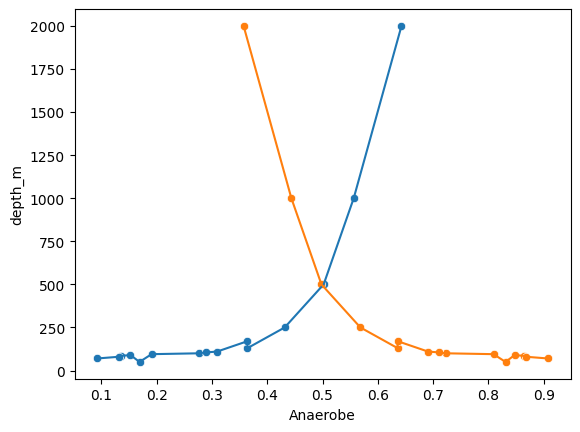

In [55]:
sns.scatterplot(x="Anaerobe",y="depth_m",data=df)
sns.lineplot(x="Anaerobe",y="depth_m",data=df)

sns.scatterplot(x="Aerobe",y="depth_m",data=df)
sns.lineplot(x="Aerobe",y="depth_m",data=df)
